# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
This project identifies lane lines on the road.  Full write-up [ here](https://github.com/jshor/CarND-LaneLines-P1/blob/master/writeup.md).

Settings can be adjusted in the top of the Helper Functions section.

Have fun!

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [45]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


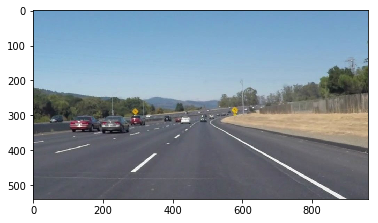

In [46]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

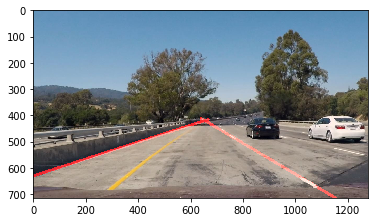

In [48]:
## Settings ##
rho                       = 1
theta                    = np.pi / 180
threshold                = 50
min_line_length          = 10
max_line_gap             = 100
kernel_size              = 5
hspace                   = 10
vspace                   = 50
low_threshold            = 50
high_threshold           = 150
roadline_angle           = 60
roadline_angle_threshold = 15


# Applies the Grayscale transform
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Applies the Canny transform
def canny(img):
    return cv2.Canny(img, low_threshold, high_threshold)

# Applies a Gaussian Noise kernel
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_hough_lines(img):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                           minLineLength=min_line_length, maxLineGap=max_line_gap)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

# returns a trapezoidal area of interest with x/y offsets
def region_of_interest_vertices(image):
    height   = image.shape[0]
    width    = image.shape[1]
    vertices = [
        [0, height], # bottom left
        [width, height], # bottom right
        [width / 2 + hspace, height / 2 + vspace], # apex
        [width / 2 - hspace, height / 2 + vspace]
    ]
    return np.int32( np.array(vertices, dtype=np.int32) )

# returns angle of line in degrees
def get_angle(line):
    x1,y1,x2,y2 = line[0]
    return math.degrees( math.atan2( (x2 - x1) , (y2 - y1) ) )

# returns midpoint of a given line
def get_midpoint(line):
    x1,y1,x2,y2 = line[0]
    
    return ( ((x2 + x1) / 2), ((y2 + y1) / 2) )

# check if angle of line is within a threshold of a given angle
def is_relatively_angled(line, angle, threshold, offset=0):
    if offset != 0:
        angle = offset - angle
    return math.fabs( get_angle(line) - angle ) < threshold

# scales a line to the bottom edge of the image to the apex of the region of interest
def scale_line(line, bottom_y, top_y):
    x1,y1,x2,y2 = line[0]
    angle = get_angle(line)
    angle = math.radians(angle)
    midpoint = get_midpoint(line)
    midpoint_x, midpoint_y = midpoint
    
    bottom_x = midpoint_x + ( bottom_y - midpoint_y ) * math.tan( angle )
    
    top_x = midpoint_x + ( top_y - midpoint_y ) * math.tan( angle )
    
    return ( (int(bottom_x), int(bottom_y)), (int(top_x), int(top_y)) )

# takes the given set of lines, extracts the ones which are within an angle threshold of angle
# and returns a solid single line that fits the region of interest
def get_optimized_line(lines, angle, threshold, bottom_y, offset):
    valid_lines = []
    min_y = bottom_y
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if is_relatively_angled(line, 60, 15, offset):
                min_y = min(min_y, y1, y2)
                valid_lines.append(line)

    try:
        return scale_line(
            np.average( valid_lines, 0 ).astype(int), # average of the lines
            bottom_y, min_y
        )
    except IndexError:
        return lines[0]

# return an image with only content from the region of interest
def get_region_of_interest(img):
    dims = region_of_interest_vertices(img)
    return region_of_interest(img, [dims])

# performs transformations on image to return a canny'd area of interest
def get_search_region(img):
    gray = grayscale(img)
    blur_gray = gaussian_blur(gray)
    blur_gray = canny(blur_gray)
    
    return get_region_of_interest(blur_gray)

# draws given lines onto given img
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# draws an optimized* line onto given img
def draw_lines_optimized(img, lines, color=[255, 0, 0], thickness=10):
    height = img.shape[0]
    width = img.shape[1]
    
    for offset in [0, 180]: # degrees offset of angle; 0 = right lane, 180 = left lane
        try:
            p1,p2 = get_optimized_line(lines, roadline_angle, roadline_angle_threshold, height, offset)

            cv2.line(img, p1, p2, color, thickness)
        except ValueError:
            pass

def render_image(img, is_optimized=False):
    blur_gray = get_search_region(img)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    line_image = np.copy(img) * 0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = get_hough_lines(blur_gray)
    
    if is_optimized is True:
        draw_lines_optimized(line_image, lines)
    else:
        draw_lines(line_image, lines)
        
    return weighted_img(img, line_image)

#reading in an image
image = mpimg.imread('test_images/test.jpg')

plt.imshow( render_image(image, True) )

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [49]:
import os

in_dir  = "test_images/"
out_dir = "test_images_output/"
files   = os.listdir(in_dir)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

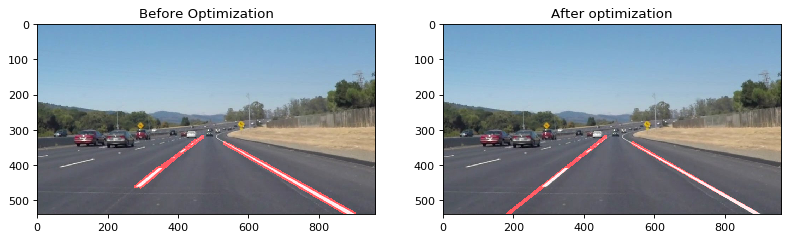

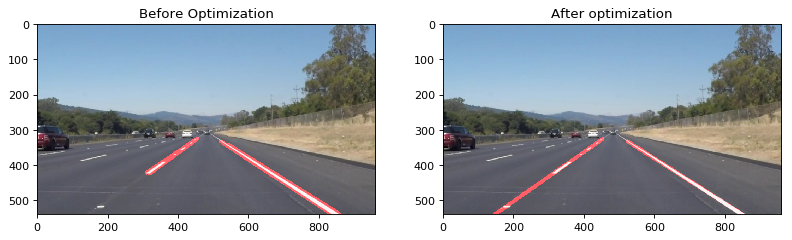

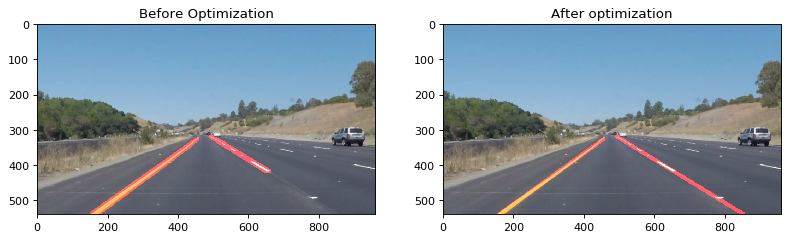

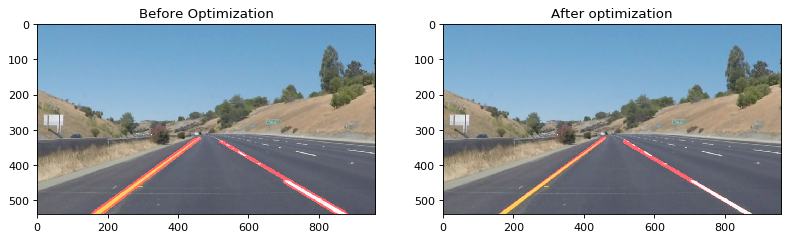

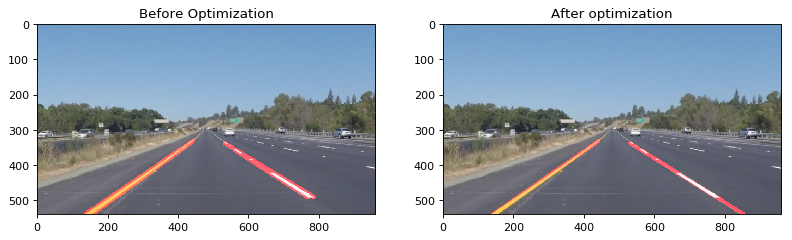

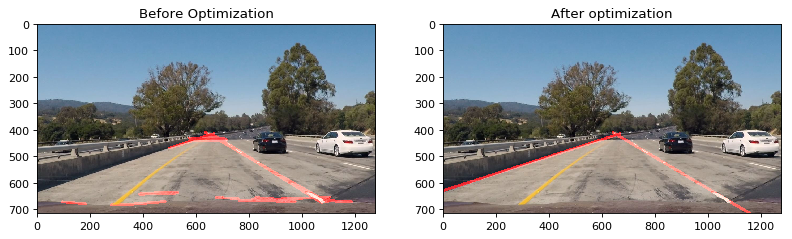

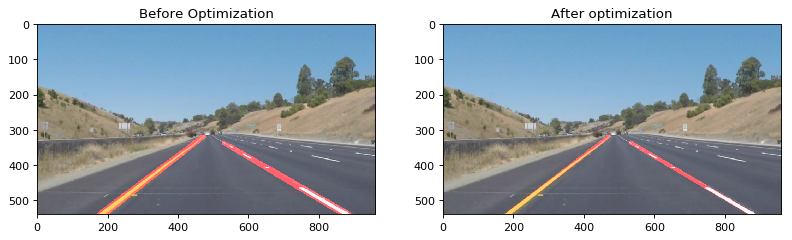

In [50]:
def render_test_images(output_optimized=False):
    for file in files:
        image = mpimg.imread(in_dir + file)

        fig = plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
        
        # without optimized lines
        a = fig.add_subplot(1,2,1)
        imgplot = plt.imshow( render_image(image) )
        a.set_title('Before Optimization')
        
        # with optimized lines
        a = fig.add_subplot(1,2,2)
        imgplot = plt.imshow( render_image(image, True) )
        a.set_title('After optimization')

        mpimg.imsave(out_dir + file, render_image(image, output_optimized))

render_test_images()

## Test on Videos

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
def process_image(image):
    return render_image(image)

Let's try the one with the solid white lane on the right first ...

In [53]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:02<00:00, 81.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.01 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [55]:
HTML("""
<h1>Non-Optimized Lines Test</h1>
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

This uses the line optimization method

In [56]:
def process_image_optimized(image):
    return render_image(image, True)

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_optimized)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:08<00:00, 80.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 8.8 s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

In [60]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image_optimized)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:06<00:00, 41.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 6.6 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))